# CAM을 만들고 평가해 보자

## 1. 라이브러리 버전 확인하기

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


In [2]:
# 라이브러리 불러오기
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('완료')

완료


In [3]:
# gpu 확인하기
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# 데이터 불러오기
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('완료')

완료


In [5]:
# 데이터셋의 메타 정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인하기
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [7]:
# CAM 구현을 위한 기본 모델 만들기
# 데이터셋의 클래스 수를 저장
num_classes = ds_info.features["label"].num_classes

# ResNet50 모델을 사전 학습된 가중치와 함께 로드
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기의 최상위 fully connected layer를 제거
    weights='imagenet',   # 사전 학습된 ImageNet 가중치를 사용
    input_shape=(224, 224, 3),  # 입력 이미지의 크기 (224x224 RGB 이미지)
    pooling='avg'         # Global Average Pooling(GAP) 레이어를 자동으로 추가
)

# ResNet50의 출력 텐서를 변수 `x`에 저장
x = base_model.output

# 최종 Dense 레이어 추가: 클래스 개수에 맞춰 softmax 활성화 함수를 사용
# 이 레이어는 각 클래스에 대한 확률 분포를 출력
preds = keras.layers.Dense(num_classes, activation='softmax')(x)

# ResNet50 기반으로 CAM 모델 생성
# 입력: ResNet50의 입력, 출력: Dense 레이어의 출력
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
# cam 모델 확인하기
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [21]:
# 이미지 데이터를 전처리하고, 효율적인 데이터 파이프라인을 구축하기 위해 수행된다
def normalize_and_resize_img(input):
    # 이미지 데이터 정규화 및 크기 조정
    # 'uint8' 데이터를 'float32'로 변환하고 크기를 224x224로 조정
    image = tf.image.resize(input['image'], [224, 224])  # 이미지를 224x224 크기로 조정
    input['image'] = tf.cast(image, tf.float32) / 255.0  # uint8(0~255) 데이터를 float32(0~1)로 정규화
    return input['image'], input['label']  # 정규화된 이미지와 레이블을 반환

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    # 데이터셋에 정규화 및 배치 처리 적용
    ds = ds.map(
        normalize_and_resize_img,  # 데이터셋의 각 이미지를 정규화 및 크기 조정
        num_parallel_calls=2       # 병렬로 데이터를 2개의 코어에서 처리
    )
    ds = ds.batch(batch_size)      # 지정된 크기만큼 배치로 묶음
    
    '''
    # 테스트 데이터가 아닌 경우 데이터 반복 및 셔플링
    if not is_test:
        ds = ds.repeat()           # 데이터셋을 무한 반복 (모델 학습 시 사용)
        ds = ds.shuffle(200)       # 200개의 버퍼 크기로 데이터 셔플링
    '''
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  # 데이터 로드와 학습을 병렬 처리하여 성능 최적화
    return ds  # 처리된 데이터셋 반환

print('완료')

완료


In [22]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
# 학습하기
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=5,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 160s 203ms/step - loss: 2.2257 - accuracy: 0.4391 - val_loss: 3.0916 - val_accuracy: 0.2450
Epoch 2/20
750/750 [==============================] - 151s 202ms/step - loss: 0.6361 - accuracy: 0.8329 - val_loss: 1.2520 - val_accuracy: 0.6379
Epoch 3/20
750/750 [==============================] - 151s 201ms/step - loss: 0.1736 - accuracy: 0.9751 - val_loss: 1.0390 - val_accuracy: 0.6980
Epoch 4/20
750/750 [==============================] - 151s 202ms/step - loss: 0.0570 - accuracy: 0.9969 - val_loss: 0.9579 - val_accuracy: 0.7298
Epoch 5/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0269 - accuracy: 0.9995 - val_loss: 0.9795 - val_accuracy: 0.7246
Epoch 6/20
750/750 [==============================] - 152s 202ms/step - loss: 0.0183 - accuracy: 0.9998 - val_loss: 0.9595 - val_accuracy: 0.7352
Epoch 7/20
750/750 [==============================] - 167s 223ms/step - loss: 0.0134 - accuracy: 0.9998 - val_loss: 1.0059 -

In [12]:
# Q. '/aiffel/class_activation_map' 에 'cam_model1.h5'을 저장하세요.
import os

cam_model_path = os.path.join('/aiffel/class_activation_map', 'cam_model1.h5')
# 모델 저장
cam_model.save(cam_model_path)

print(f"모델이 저장되었습니다: {cam_model_path}")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


모델이 저장되었습니다: /aiffel/class_activation_map/cam_model1.h5


In [ ]:
## 모델 결과 시각화
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_vgg18_model.history['accuracy'], 'r', label="train_acc")
plt.plot(history_vgg18_model.history['val_accuracy'], 'b', label="valid_acc")
plt.title('vgg18_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_vgg18_model.history['loss'], 'r', label="train_loss")
plt.plot(history_vgg18_model.history['val_loss'], 'b', label="valid_loss")
plt.title('vgg18_model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

## 모델 불러오기

In [17]:
# CAM 생성을 위해 미리 준비된 학습한 모델 불러오기
import os
cam_model_path = os.getenv('HOME')+'/class_activation_map/cam_model_resnet50_best_val_loss.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('완료')

완료


## 사진 샘플 뽑기

40


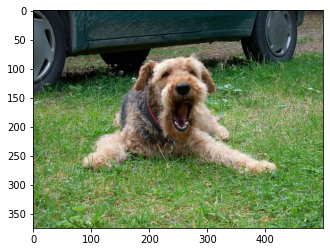

In [38]:
# 사진 샘플 뽑기 함수 정의
def get_one(ds):
    
    # 데이터셋에서 첫 번째 배치(1개의 샘플)를 가져옴
    ds = ds.take(1)
    # 데이터셋을 리스트로 변환 (데이터를 numpy 배열로 처리)
    sample_data = list(ds.as_numpy_iterator())
    # 샘플 데이터에서 바운딩 박스 정보 추출
    bbox = sample_data[0]['objects']['bbox']  
    # 샘플 데이터에서 이미지 정보 추출
    image = sample_data[0]['image']
    # 샘플 데이터에서 레이블 정보 추출
    label = sample_data[0]['label']
    # 샘플 데이터 반환 (이미지, 라벨, 바운딩 박스 정보 포함)
    return sample_data[0]

# 테스트 데이터셋에서 하나의 샘플을 추출
item = get_one(ds_test)

# 샘플의 레이블 출력
print(item['label'])
plt.imshow(item['image'])
plt.show()


## 2. CAM 구현하기
1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요
2. 만든 함수로 CAM 이미지를 생성합시다
3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요

In [39]:
# CAM 생성 함수
def generate_cam(model, item):

    item = copy.deepcopy(item)

    # 이미지의 너비와 높이를 저장
    # CAM을 생성한 후 원본 이미지 크기로 변환하기 위해 사용
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # 이미지 데이터를 정규화하고 모델 입력 형식으로 변환
    img_tensor, class_idx = normalize_and_resize_img(item)
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    
    # CAM 모델에 이미지를 전달하여, 특징 맵과 클래스 예측값을 얻음
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))  # 배치 차원 추가
    conv_outputs = conv_outputs[0, :, :, :]  # 배치 차원 제거하여 3D 텐서로 변환
    
    # 마지막 Dense 레이어에서 클래스별 가중치(weight)를 추출
    # `model.layers[-1].get_weights()[0]`는 Dense 레이어의 가중치를 반환
    class_weights = model.layers[-1].get_weights()[0] 
    
    # CAM 이미지를 저장할 빈 numpy 배열 생성 (conv_outputs의 첫 두 차원 크기 사용)
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    
    # 각 필터의 활성화 맵(conv_outputs)과 해당 클래스의 가중치를 곱해 CAM 이미지 생성
    for i, w in enumerate(class_weights[:, class_idx]):
        # i번째 필터의 활성화 맵(conv_outputs[:, :, i])과 i번째 가중치(w)를 곱하여 누적
        cam_image += w * conv_outputs[:, :, i]

    # 활성화 맵을 0~1 범위로 정규화
    cam_image /= np.max(cam_image)  # 활성화 점수를 정규화
    
    # TensorFlow 텐서를 NumPy 배열로 변환
    cam_image = cam_image.numpy()
    
    # CAM 이미지를 원본 이미지 크기로 리사이즈
    cam_image = cv2.resize(cam_image, (width, height))  # OpenCV를 사용하여 리사이즈
    return cam_image  # 최종 생성된 CAM 이미지 반환


완료


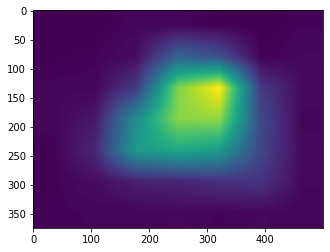

In [40]:
# CAM 확인하기
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

## visualize_cam_on_image() 만들기

In [41]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

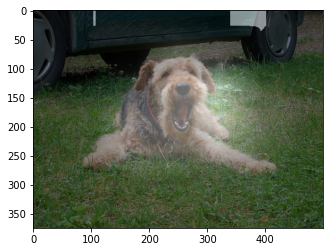

In [42]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 3. Grad-CAM 구현하기
1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요
2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요
3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요

In [43]:
# Grad-CAM 구현하기
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('완료')

완료


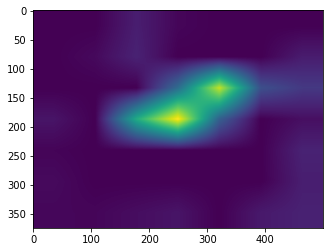

In [44]:
# Grad-CAM 확인하기
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

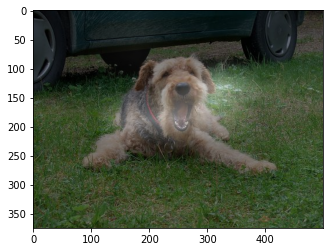

In [45]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_grad_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_grad_image)
plt.show()

## 4. 바운딩 박스 구하기
1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요
2. 1)에서 얻은 바운딩 박스를 시각화해 보세요

In [46]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('완료')

완료


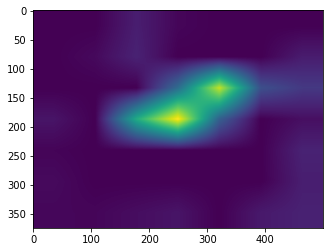

In [47]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [48]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('완료')

완료


In [49]:
rect = get_bbox(cam_image)
rect

array([[ 64, 312],
       [ 85,  20],
       [465,  48],
       [445, 339]])

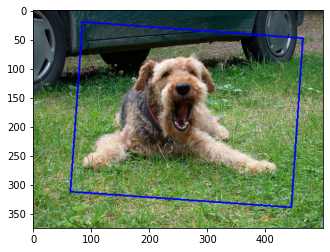

In [50]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## 5. IoU 구하기
1. 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요
2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다

In [ ]:
def get_iou(gt_bbox, pred_bbox):
    iou = None
    # TODO: get iou between two bbox
    return iou